In [1]:
# Download data, execute this block once in a while
# checks if dataset is downloaded at data/covid19-severity-prediction
# updating to the latest version
# Note: this can take a while if you don't have the dataset in data/covid19-severity-prediction

from utils import *

updating to the latest version
update successful
current working dir: d:\dataset\CS184A-Covid19_severity_prediction


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [3]:
import load_data
from Project_Models import RNN_Model, LSTM_Model
import torch
import torch.nn as nn

print("current device:", torch.cuda.get_device_name(torch.cuda.current_device()))

def normalize(x):
    """ normalize data of each column """
    maxtensor = x.max(0, keepdim=True)[0]
    maxtensor[maxtensor==0] = 1e-4
    x_normed = x / maxtensor
    return x_normed, maxtensor

def standardize(x):
    mean = x.mean(0, keepdim=True)[0]
    mean[mean==0] = 1e-4
    std  = x.std(0, keepdim=True)[0]
    std[std==0] = 1e-4
    x_normed = (x - mean) / std
    return x_normed, mean, std

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
df = load_data.load_county_level('./data/covid19-severity-prediction/data')

current device: GeForce RTX 3080
loading county-level data...
loaded and merged COVID-19 cases/deaths data successfully


In [4]:
def to_numpy(x):
    """Convert a PyTorch tensor to NumPy."""
    return x.squeeze().detach().cpu().numpy()

def to_torch(x, device='cpu'):
    return torch.tensor(x).unsqueeze(-1).to(device).float()

In [12]:
FEATURES = [
    '#Hospitals', 
    '#ICU_beds', 
    'lat', 'lon','POP_LATITUDE', 'POP_LONGITUDE',
    # '#EligibleforMedicare2018',
    # 'MedicareEnrollment,AgedTot2017', 
    'DiabetesPercentage', 
    'HeartDiseaseMortality',
    'StrokeMortality',
    'Smokers_Percentage',
    'RespMortalityRate2014',
    '#FTEHospitalTotal2017',
    "TotalM.D.'s,TotNon-FedandFed2017",
    '#HospParticipatinginNetwork2017']

FEATURES = [
    '#Hospitals', 
    '#ICU_beds', 
    'MedicareEnrollment,AgedTot2017', 
    'DiabetesPercentage', 
    'HeartDiseaseMortality',
    'StrokeMortality',
    'Smokers_Percentage',
    'RespMortalityRate2014',
    '#FTEHospitalTotal2017',
    "TotalM.D.'s,TotNon-FedandFed2017",
    '#HospParticipatinginNetwork2017']

    # ,    
    # 'stay at home',
    # '>50 gatherings',
    # '>500 gatherings',
    # 'public schools',
    # 'restaurant dine-in',
    # 'entertainment/gym',
    # 'federal guidelines',
    # 'foreign travel ban',
    # 'SVIPercentile',
    # 'HPSAShortage',
    # 'HPSAServedPop',
    # 'HPSAUnderservedPop'

In [13]:
# Preprocess Data

maxload = 1600 #

x = form_input_tensor(df, FEATURES,
    maxload=maxload).to(device)
x, xmaxtensor = normalize(x)
# x[torch.isnan(x)] = 0
print(f"#x nan: {(torch.sum(torch.isnan(x)))}")
# print("x:", x)

y = form_labels_tensor(df, maxload=maxload).to(device)
y, ymaxtensor = normalize(y)
print(f"#y nan: {torch.sum(torch.isnan(y))}")
# print("y:", y * ymaxtensor)

Xtrain = x[:-50]
Ytrain = y[:-50]
Xtest  = x[90:]
Ytest  = y[90:]

#x nan: 0
#y nan: 0


In [17]:
# Saving the model
# torch.save(model, "saved_model/first100dataloss=0.model")

In [18]:
# TODO
# 1. Batch Gradient Descent using dataloader
# 2. Handle NaN case

In [76]:
# df['CountyName'] == 'Orange'
# df.columns.to_list()

In [14]:
import torch
import torch.nn as nn

class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        self.casefc1 = nn.Linear(hidden_size, 64)
        self.casefc2 = nn.Linear(64, 32)
        self.casefc3 = nn.Linear(32, 1)

        self.deathfc1 = nn.Linear(hidden_size, 64)
        self.deathfc2 = nn.Linear(64, 32)
        self.deathfc3 = nn.Linear(32, 1)

        self.activation=nn.ReLU()

    def forward(self, x):
        h0 = torch.ones(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.ones(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]

        # res block 1
        r1 = self.casefc1(out)
        case = self.activation(r1) + r1
        # res block 2
        r2 = self.casefc2(case)
        case = self.activation(r2) + r2
        # output
        case = self.casefc3(case)

        # res block 1
        d1 = self.deathfc1(out)
        d = self.activation(d1) + d1
        # res block 2
        d2 = self.deathfc2(d)
        d = self.activation(d2)
        # output
        d = self.deathfc3(d)
        return torch.hstack((case, d))

In [15]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # self.fc1 = nn.Linear(hidden_size, 64)
        # self.fc2 = nn.Linear(64, 32)
        # self.fc3 = nn.Linear(32, 2)
        # self.activation=nn.ReLU()

        self.casefc1 = nn.Linear(hidden_size, 64)
        self.casefc2 = nn.Linear(64, 32)
        self.casefc4 = nn.Linear(32, 32)
        self.casefc5 = nn.Linear(32, 32)
        self.casefc3 = nn.Linear(32, 1)

        self.deathfc1 = nn.Linear(hidden_size, 64)
        self.deathfc2 = nn.Linear(64, 32)
        self.deathfc3 = nn.Linear(32, 1)

        self.residule = nn.Linear

        self.activation=nn.ReLU()


    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        out, _ = self.rnn(x, h0)
        out = out[:, -1, :]

        # out = self.activation(self.fc1(out))
        # out = self.activation(self.fc2(out))
        # out = self.fc3(out)
        # return out

        # res block 1
        r1 = self.casefc1(out)
        case = self.activation(r1) + r1
        # res block 2
        r2 = self.casefc2(case)
        case = self.activation(r2) + r2
        # res block 3
        r3 = self.casefc4(case)
        case = self.activation(r3) + r3
        # res block 4
        r4 = self.casefc5(case)
        case = self.activation(r4)
        # output
        case = self.casefc3(case)

        # res block 1
        d1 = self.deathfc1(out)
        d = self.activation(d1) + d1
        # res block 2
        d2 = self.deathfc2(d)
        d = self.activation(d2)
        # output
        d = self.deathfc3(d)
        return torch.hstack((case, d))

In [31]:
# with 2e-5 reg

def trainModel(Classifier, lr, epochs):

    print("training data shape:", Xtrain.shape, Ytrain.shape)

    # train model
    model = Classifier(input_size=Xtrain.shape[2], hidden_size=128, num_layers=3).to(device)
    # with torch.no_grad():
    #     print("Before training:", model(Xtrain) * ymaxtensor)

    criterion = lambda y, yhat: torch.sqrt(nn.MSELoss()(y, yhat))
    # criterion = nn.SmoothL1Loss()
    learning_rate = lr
    num_epoches = epochs
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    trange = tqdm.trange(num_epoches)
    for epoch in trange:
        # for i in range(1, Xtrain.shape[1]):
        #     yhat = model(Xtrain[:,:i,:])
        #     loss = criterion(yhat, Xtrain[:,i,-2:])
        #     optimizer.zero_grad()
        #     loss.backward()
        #     optimizer.step()
        #     trange.set_description(f'Epoch [{epoch + 1}/{num_epoches}], Loss: {loss.item():.4f}')
        #     trange.refresh()
        yhat = model(Xtrain)
        loss = criterion(yhat, Ytrain)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        trange.set_description(f'Epoch [{epoch + 1}/{num_epoches}], Loss: {loss.item():.4f}')
        trange.refresh()

    # with torch.no_grad():
    #     print("After training:", (model(Xtest) * ymaxtensor))
    #     print("y:", (Ytest * ymaxtensor))
    
    return model

In [32]:

def plotPrediction(df):
    x = form_input_tensor(df, FEATURES, maxload=maxload).to(device)
    truey = x[:, :, -2:]
    xnorm = x / xmaxtensor
    x[torch.isnan(x)]=0
    print(f"#x nan: {(torch.sum(torch.isnan(x)))}")
    # print("x:", x * )
    y = form_labels_tensor(df, maxload=maxload).to(device)
    ynorm = y / ymaxtensor
    print(f"#y nan: {torch.sum(torch.isnan(y))}")

    yhat = torch.zeros((x.shape[1], 2), dtype=torch.float32, device='cuda')
    for i in range(1, x.shape[1]):
        yhati = None
        with torch.no_grad():
            yhati = model(xnorm[:,:i,:])
        yhati *= ymaxtensor
        yhat[i] = (yhati)
    # print(yhat)

    truey = to_numpy(truey)
    yhat = to_numpy(yhat)
    plt.figure(figsize=(16,4))
    # plt.ylim((0, 70000))
    plt.plot(range(len(truey)),truey[:,0],'r-')
    plt.plot(range(len(truey)),yhat[:,0],'g-')
    # plt.plot(range(len(truey)), np.absolute(truey[:,0]-yhat[:,0]), 'b-')
    print("mse", np.sum((truey[:,0] - yhat[:,0]) ** 2) / len(truey))
    plt.show()
    plt.figure(figsize=(16,4))
    plt.plot(range(len(truey)),truey[:,1],'r-')
    plt.plot(range(len(truey)),yhat[:,1],'g-')
    # plt.plot(range(len(truey)), np.absolute(truey[:,1]-yhat[:,1]), 'b-')
    print("mse", np.sum((truey[:,1] - yhat[:,1]) ** 2) / len(truey))
    plt.show()

In [29]:
model = trainModel(RNN, 1e-3, 200)

Epoch [200/200], Loss: 0.0061: 100%|██████████| 200/200 [00:11<00:00, 17.35it/s]


In [20]:
orange = df[(df['StateName'] == 'CA') & (df['CountyName'] == 'Orange')]

#x nan: 0
#y nan: 0
mse 3884384256.0


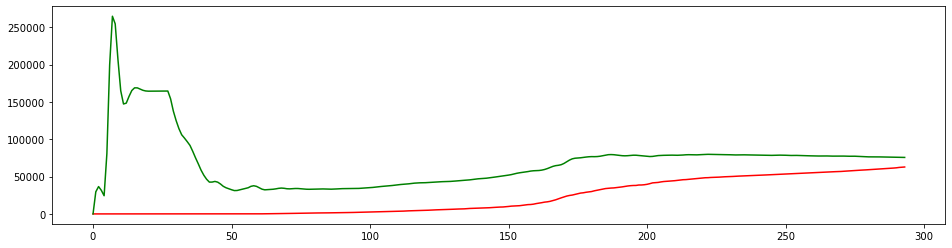

mse 111180.42176870749


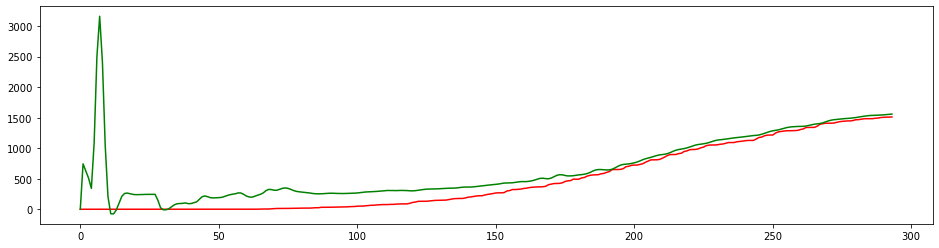

In [30]:
plotPrediction(orange)

#x nan: 0
#y nan: 0
mse 3289501500.952381


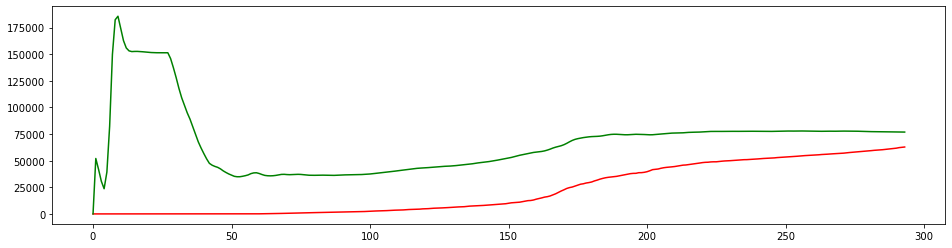

mse 103381.98639455783


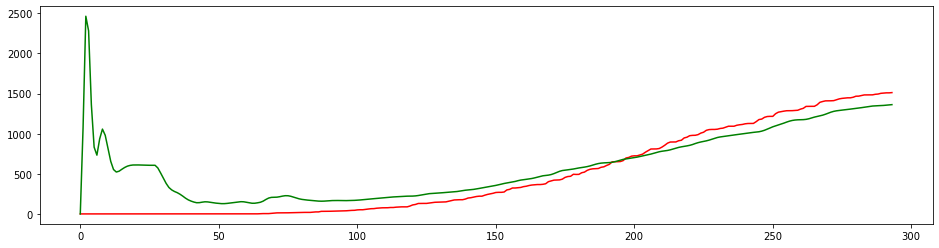

In [22]:
plotPrediction(orange)

In [23]:
LA = df[(df['StateName'] == 'CA') & (df['CountyName'] == 'Los Angeles')]

#x nan: 0
#y nan: 0
mse 21170788672.435375


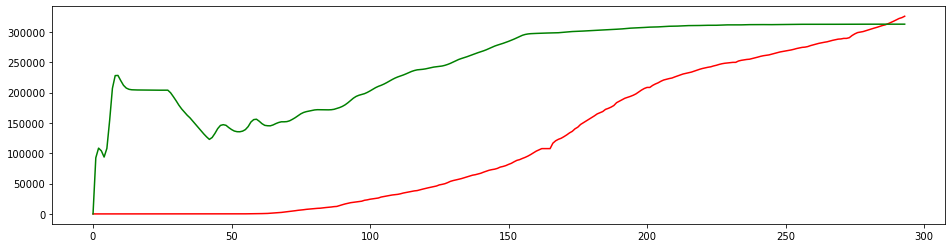

mse 588177.306122449


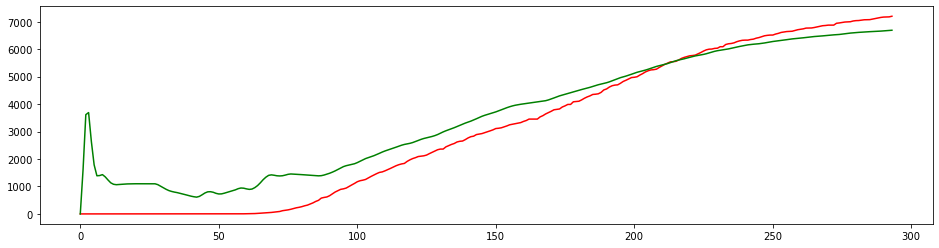

In [24]:
plotPrediction(LA)

In [25]:
model = trainModel(RNN, 1e-3, 200)

Epoch [78/200], Loss: 0.0002:  39%|███▉      | 78/200 [00:04<00:07, 16.81it/s]


KeyboardInterrupt: 

mse 2688408206.802721


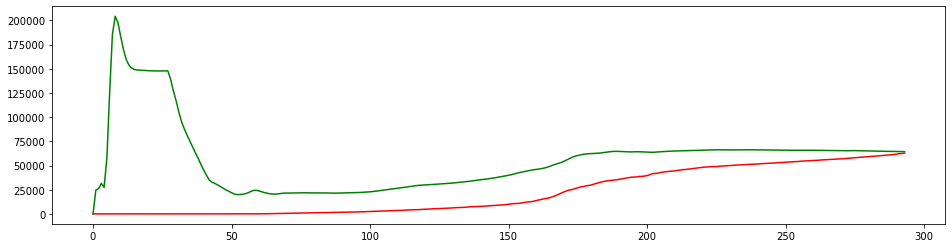

mse 39043.52380952381


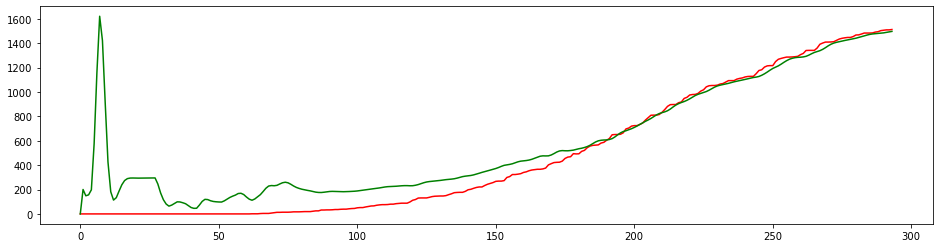

mse 17902091953.632652


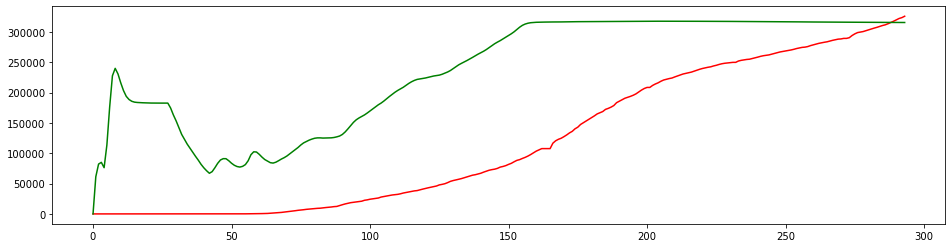

mse 365206.1768707483


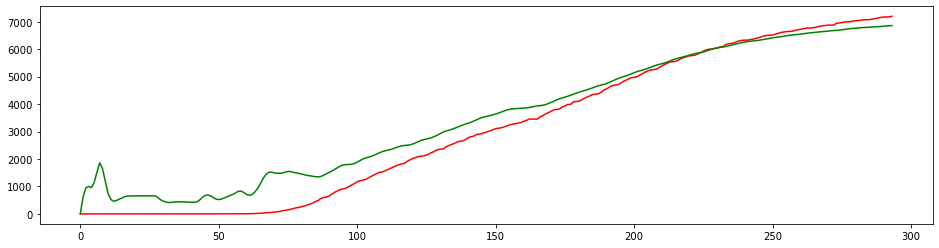

In [54]:
plotPrediction(orange)
plotPrediction(LA)

mse 3646622768.7619047


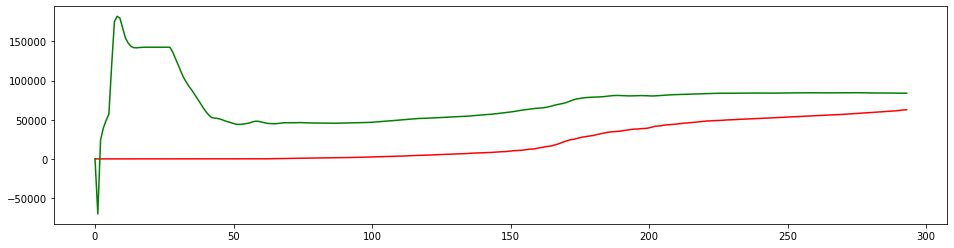

mse 192637.4693877551


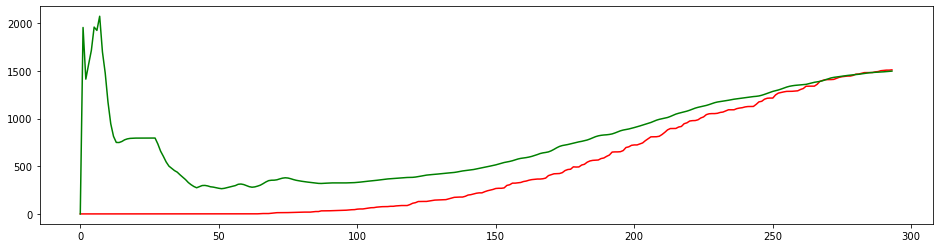

mse 28378154408.92517


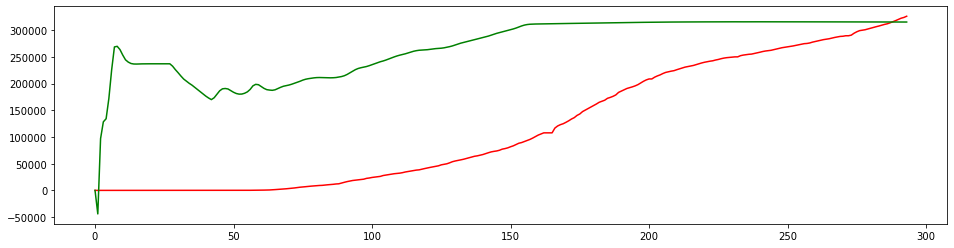

mse 1094398.693877551


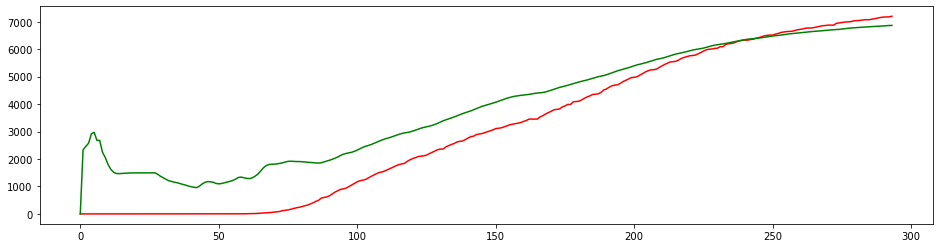

In [46]:
plotPrediction(orange)
plotPrediction(LA)

mse 3355685504.8707485


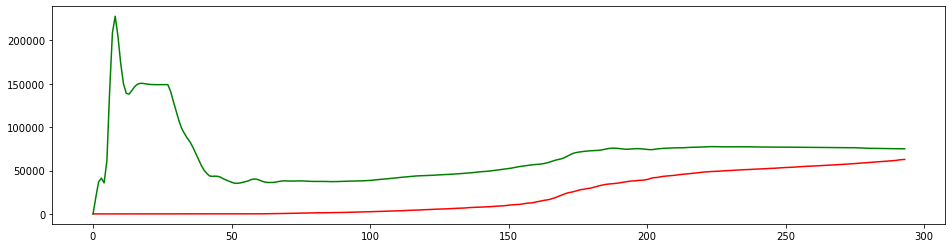

mse 117804.96598639456


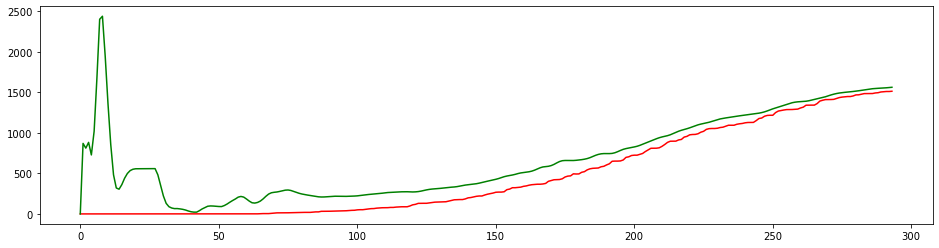

mse 24177537553.414967


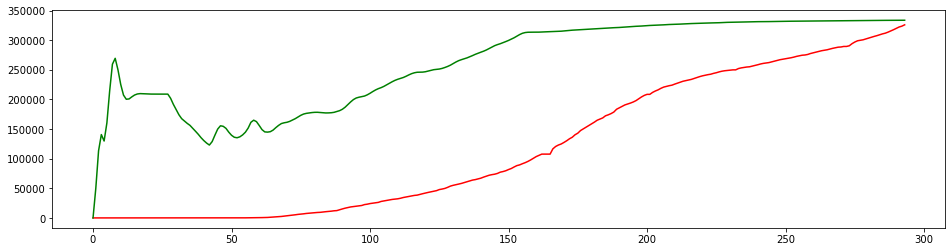

mse 858689.6870748299


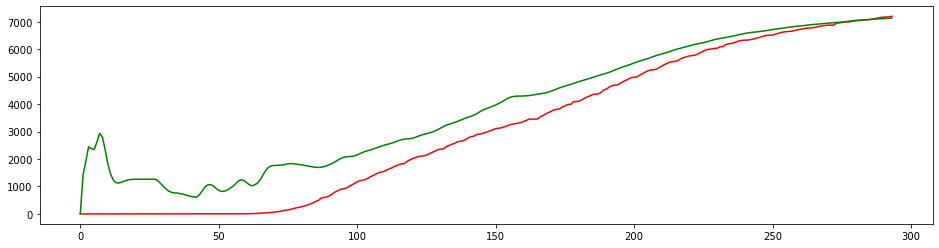

In [58]:
plotPrediction(orange)
plotPrediction(LA)

Kings NY
mse 13672512644.35374


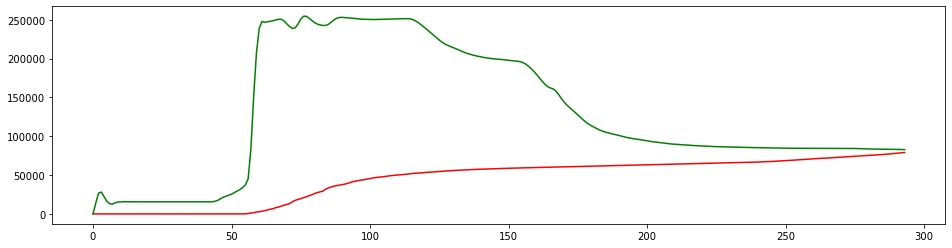

mse 2203683.9183673467


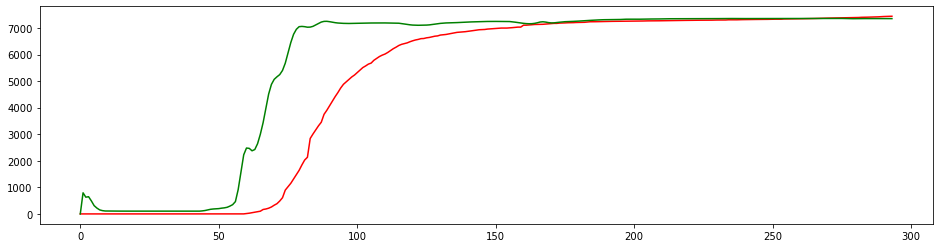

Queens NY
mse 15648627231.34694


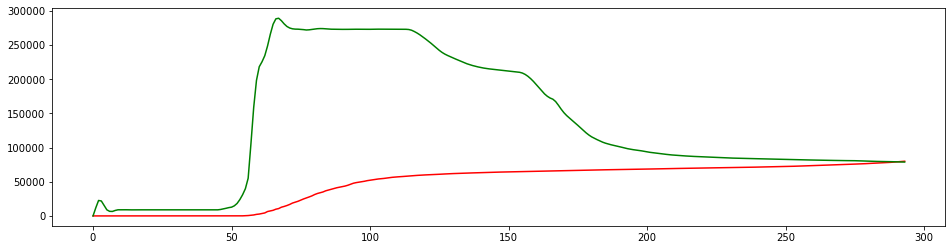

mse 2956445.8231292516


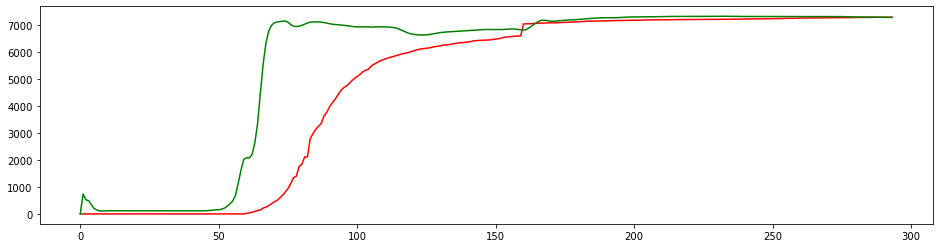

Los Angeles CA
mse 24177537553.414967


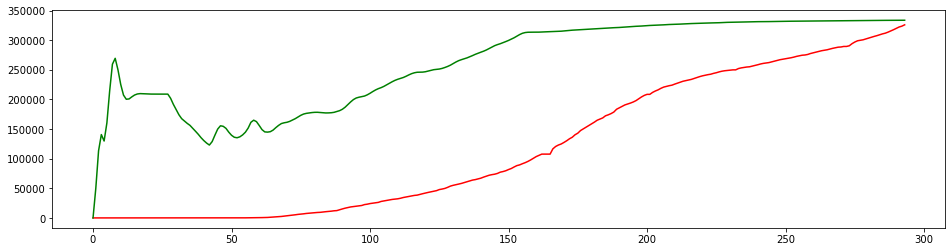

mse 858689.6870748299


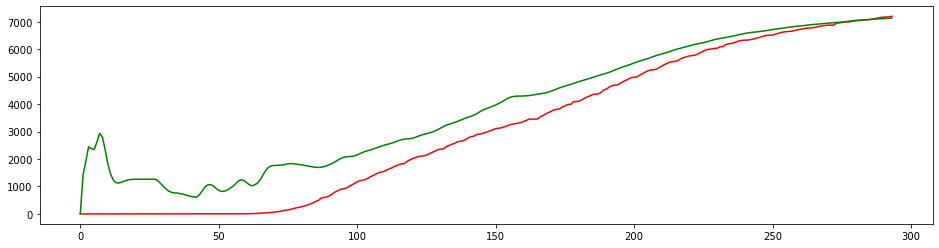

Cook IL
mse 23729442509.496597


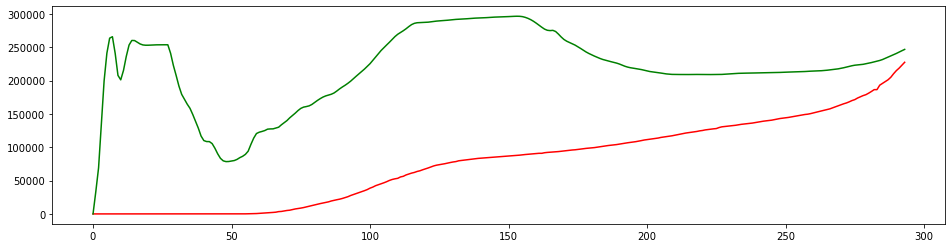

mse 627714.0680272109


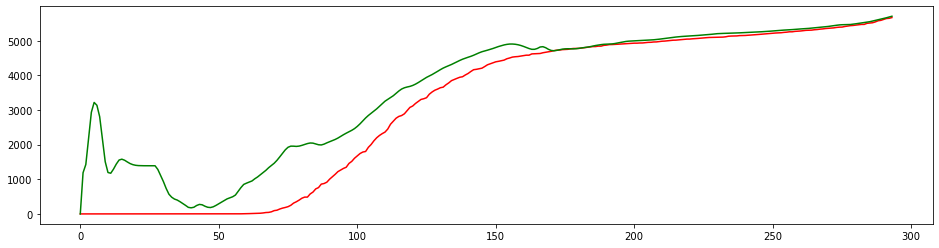

Bronx NY
mse 7966677423.891156


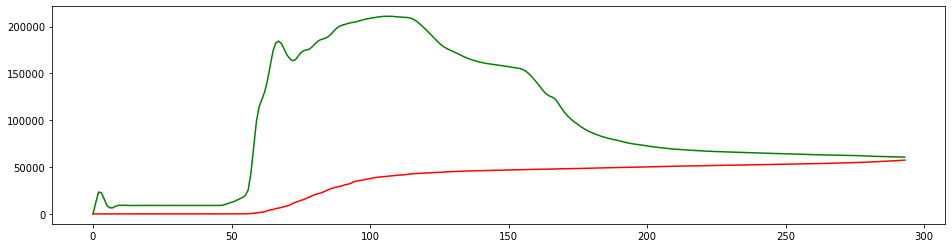

mse 1835523.2653061224


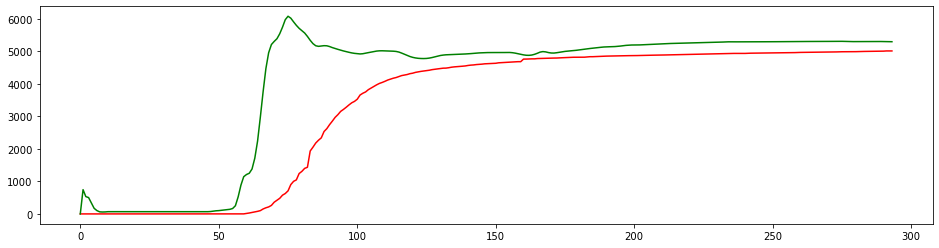

KeyboardInterrupt: Interrupted by user

In [66]:
for i, row in df[['CountyName', 'StateName']].iterrows():
    County = df[(df['StateName'] == row['StateName']) & (df['CountyName'] == row['CountyName'])]
    print(row['CountyName'], row['StateName'])
    plotPrediction(County)
    input()

mse 13672512644.35374


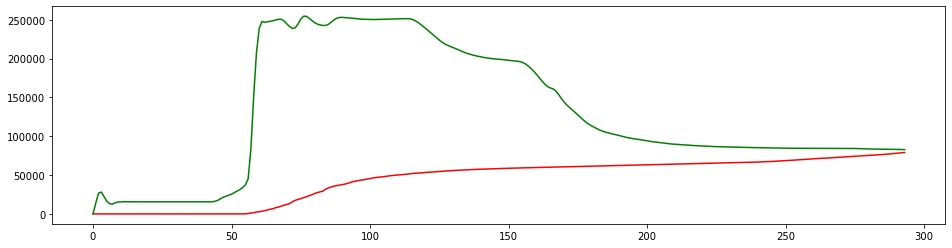

mse 2203683.9183673467


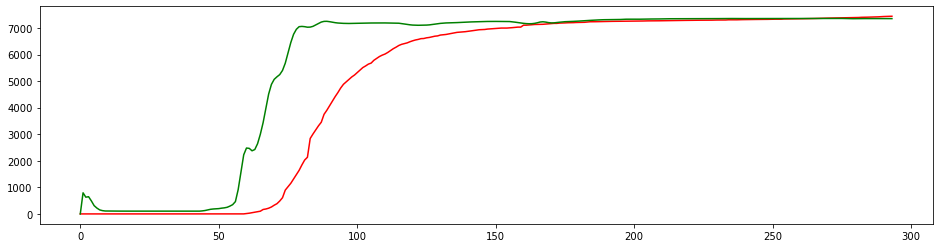

In [61]:
for county in df['']
Kings = df[(df['StateName'] == 'NY') & (df['CountyName'] == 'Kings')]
plotPrediction(Kings)

In [69]:
print("training data shape:", Xtrain.shape, Ytrain.shape)

# train model
Classifier = LSTM

model = Classifier(input_size=Xtrain.shape[2], hidden_size=256, num_layers=3).to(device)
# with torch.no_grad():
#     print("Before training:", model(Xtrain) * ymaxtensor)

criterion = nn.MSELoss()
# criterion = nn.SmoothL1Loss()
learning_rate = 1e-3
num_epoches = 100
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=2e-5)

trange = tqdm.trange(num_epoches)
for epoch in trange:
    for i in range(1, Xtrain.shape[1]):
        yhat = model(Xtrain[:,:i,:])
        loss = criterion(yhat, Xtrain[:,i,-2:])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        trange.set_description(f'Epoch [{epoch + 1}/{num_epoches}], Loss: {loss.item():.4f}')
        trange.refresh()

with torch.no_grad():
    print("After training:", (model(Xtest) * ymaxtensor))
    print("y:", (Ytest * ymaxtensor))

Epoch [1/100], Loss: 0.0024:   0%|          | 0/100 [00:04<?, ?it/s]


KeyboardInterrupt: 

mse 3223255973.442177


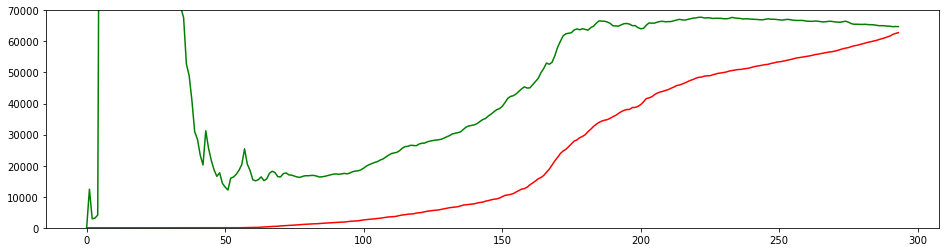

mse 22710.931972789116


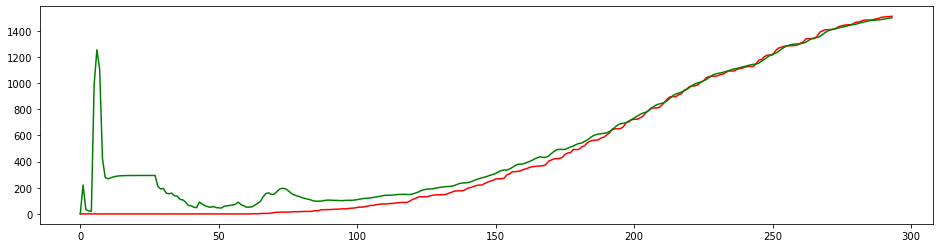

In [14]:
orange = df[(df['StateName'] == 'CA') & (df['CountyName'] == 'Orange')]

def plotPrediction(df):
    x = form_input_tensor(df, [
    '#Hospitals', 
    '#ICU_beds', 
    'MedicareEnrollment,AgedTot2017', 
    'DiabetesPercentage', 
    'HeartDiseaseMortality',
    'StrokeMortality',
    'Smokers_Percentage',
    'RespMortalityRate2014',
    '#FTEHospitalTotal2017',
    "TotalM.D.'s,TotNon-FedandFed2017",
    '#HospParticipatinginNetwork2017'], maxload=maxload).to(device)
    truey = x[:, :, -2:]
    xnorm = x / xmaxtensor
    # print(f"#x nan: {(torch.sum(torch.isnan(x)))}")
    # print("x:", x * )
    y = form_labels_tensor(df, maxload=maxload).to(device)
    ynorm = y / ymaxtensor
    # print(f"#y nan: {torch.sum(torch.isnan(y))}")

    yhat = torch.zeros((x.shape[1], 2), dtype=torch.float32, device='cuda')
    for i in range(1, x.shape[1]):
        yhati = None
        with torch.no_grad():
            yhati = model(xnorm[:,:i,:])
        yhati *= ymaxtensor
        yhat[i] = (yhati)
    # print(yhat)

    truey = to_numpy(truey)
    yhat = to_numpy(yhat)
    plt.figure(figsize=(16,4))
    plt.ylim((0, 70000))
    plt.plot(range(len(truey)),truey[:,0],'r-')
    plt.plot(range(len(truey)),yhat[:,0],'g-')
    # plt.plot(range(len(truey)), np.absolute(truey[:,0]-yhat[:,0]), 'b-')
    print("mse", np.sum((truey[:,0] - yhat[:,0]) ** 2) / len(truey))
    plt.show()
    plt.figure(figsize=(16,4))
    plt.plot(range(len(truey)),truey[:,1],'r-')
    plt.plot(range(len(truey)),yhat[:,1],'g-')
    # plt.plot(range(len(truey)), np.absolute(truey[:,1]-yhat[:,1]), 'b-')
    print("mse", np.sum((truey[:,1] - yhat[:,1]) ** 2) / len(truey))
    plt.show()

plotPrediction(orange)